### Load data


In [ ]:
!pip install sklearn_crfsuite
!pip install -U 'scikit-learn<0.24'
!git clone -b master https://github.com/charles9n/bert-sklearn
!pip install ./bert-sklearn/.

In [3]:

import pandas as pd
%matplotlib notebook
import matplotlib.pyplot as plt
import tqdm
import numpy as np
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.linear_model import Perceptron
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
import sklearn_crfsuite
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics
from collections import Counter
%pylab inline
plt.style.use('dark_background')
matplotlib.rcParams['figure.figsize'] = (16, 9)

Populating the interactive namespace from numpy and matplotlib


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Датесет в формате conll, можно распарсить предложения разбив по \n\n

In [4]:
def preprocess_conll(text, sep="\t"):
    text_list = text.split("\n\n")
    if text_list[-1] in (" ", ""):
        text_list = text_list[:-1]

    max_seq_len = 0
    sentence_list = []
    for s in text_list:
        # split each sentence string into "word label" pairs
        s_split = s.split("\n")
        # split "word label" pairs
        s_split_split = [t.split(sep) for t in s_split]
        sentence_list.append([tuple(x) for x in s_split_split if len(x[0]) > 0])

        if len(s_split_split) > max_seq_len:
            max_seq_len = len(s_split_split)
    print("Maximum sequence length is: {0}".format(max_seq_len))
    return sentence_list


def read_conll_file(file_path, sep="\t", encoding=None):
    with open(file_path, encoding=encoding) as f:
        data = f.read()
    return preprocess_conll(data, sep=sep)
train_sents = read_conll_file('drive/MyDrive/datasets/gum-train.conll')
test_sents = read_conll_file('drive/MyDrive/datasets/gum-test.conll')
train_sents[:2]

Maximum sequence length is: 94
Maximum sequence length is: 95


[[('The', 'B-object'),
  ('back', 'I-object'),
  ('of', 'I-object'),
  ('my', 'I-object'),
  ('jersey', 'I-object'),
  ('says', 'O'),
  ('"', 'B-abstract'),
  ('The', 'I-abstract'),
  ('Poet', 'I-abstract'),
  ("'", 'I-abstract'),
  ('because', 'O'),
  ('growing', 'O'),
  ('up', 'O'),
  ('that', 'B-abstract'),
  ('was', 'O'),
  ('my', 'B-person'),
  ('nickname', 'O'),
  ('.', 'O')],
 [('These', 'B-place'),
  ('hotels', 'I-place'),
  ('may', 'O'),
  ('not', 'O'),
  ('be', 'O'),
  ('the', 'O'),
  ('most', 'O'),
  ('luxerious', 'O'),
  (',', 'O'),
  ('but', 'O'),
  ('they', 'O'),
  ('do', 'O'),
  ('provide', 'O'),
  ('air-conditionting', 'B-abstract'),
  (',', 'O'),
  ('televisions', 'B-object'),
  (',', 'O'),
  ('and', 'O'),
  ('refrigerators', 'B-object'),
  ('in', 'O'),
  ('all', 'B-place'),
  ('of', 'I-place'),
  ('the', 'I-place'),
  ('rooms', 'I-place'),
  ('.', 'O')]]

In [5]:
colnames = ['word', 'tag']
ds_train = pd.read_csv('drive/MyDrive/datasets/gum-train.conll', sep='\t', names=colnames, header=None, quoting=3)
ds_test = pd.read_csv('drive/MyDrive/datasets/gum-test.conll', sep='\t', names=colnames, header=None, quoting=3)
df = pd.concat((ds_train, ds_test))
df.shape

(62347, 2)

### EDA

In [45]:
ds_train.head(5)

,word,tag
0,The,B-object
1,back,I-object
2,of,I-object
3,my,I-object
4,jersey,I-object


In [44]:
df.isnull().sum()

word    0
tag     0
dtype: int64

In [8]:
df['tag'].value_counts()

O                 29003
I-abstract         6735
I-event            3641
I-place            3138
B-abstract         2800
B-person           2743
I-person           2551
I-object           2514
B-place            1619
B-object           1437
B-event            1053
I-time              905
I-organization      830
I-substance         641
B-organization      589
B-time              580
B-substance         373
I-quantity          280
I-plant             222
B-plant             206
B-animal            183
I-animal            163
B-quantity          141
Name: tag, dtype: int64

Теги вполне сбалансированы, и тег О всего примерно 60 проц

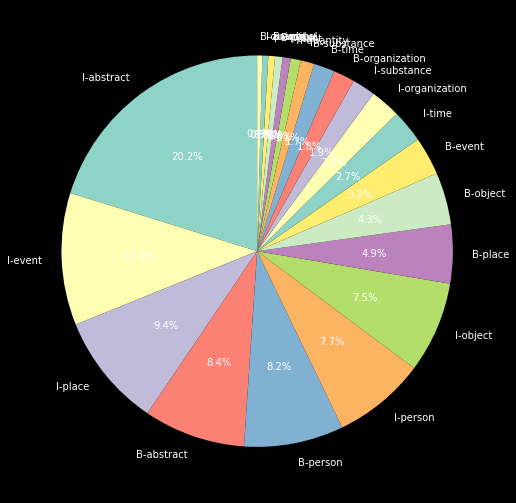

In [9]:
cnts = df['tag'].value_counts().drop('O')
p = plt.pie(cnts.values, labels=cnts.index, autopct='%1.1f%%', startangle=90)

Остальные теги тоже вполне равномерно распределены

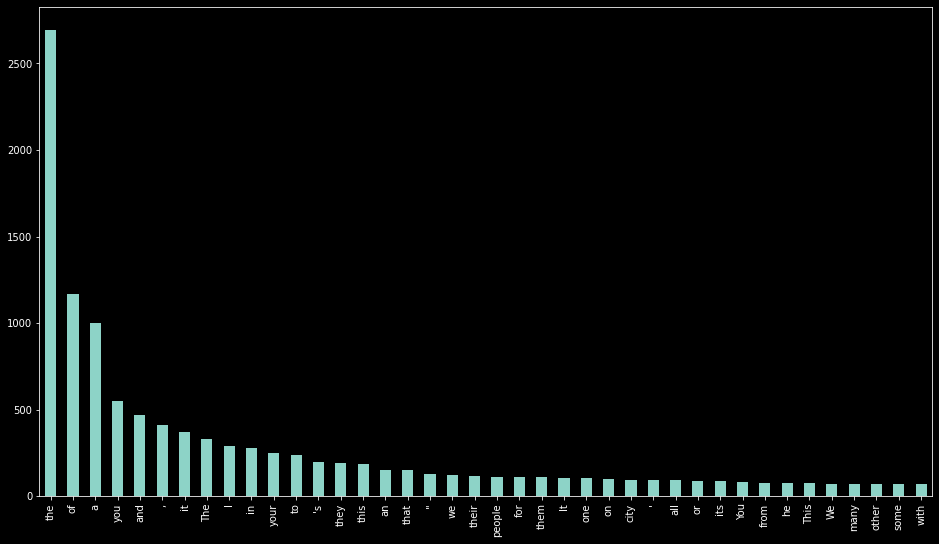

In [10]:
words_counts = df[df['tag'] != 'O']['word'].value_counts()[:40].plot(kind='bar')

Посмотрим на наиболее частые слова и их теги

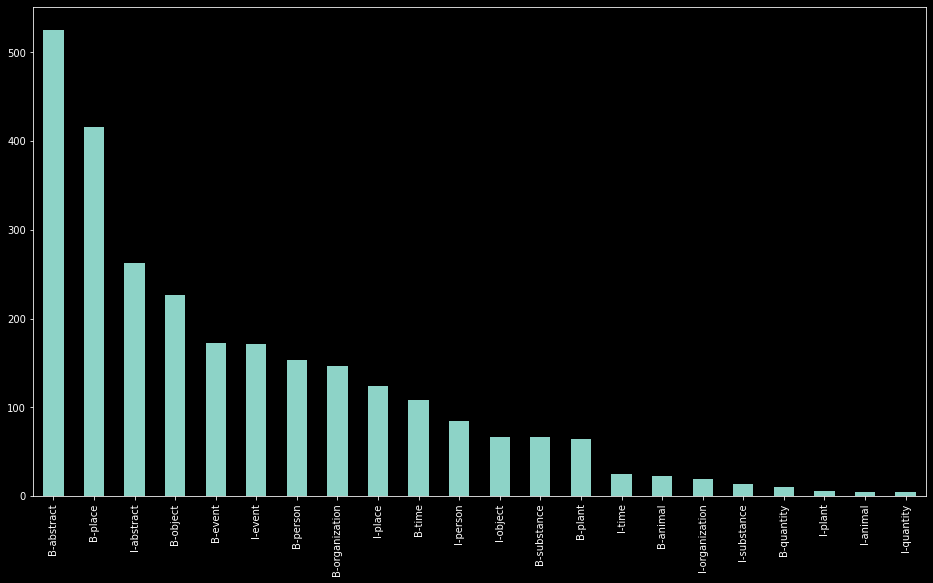

In [11]:
df[df['word'] == 'the']['tag'].value_counts().drop('O').plot(kind='bar')

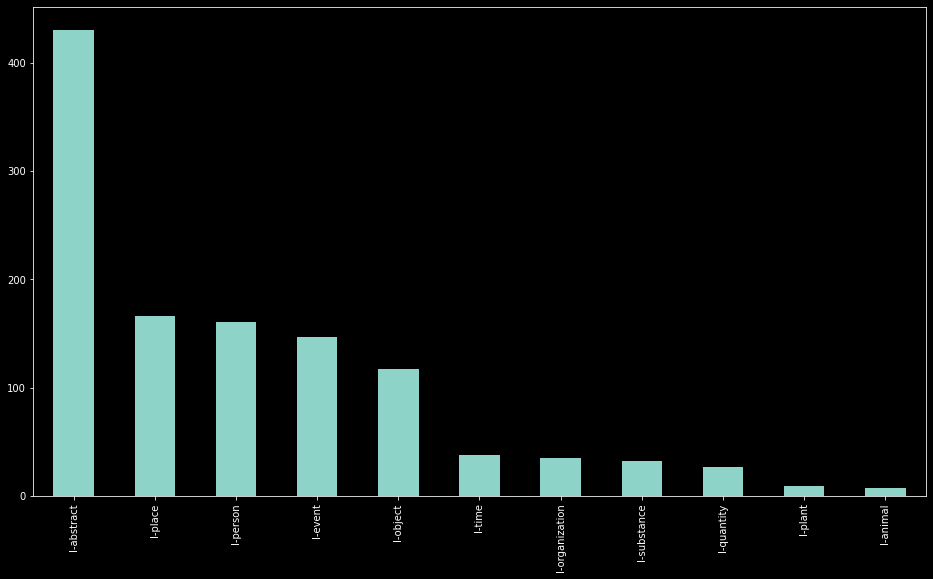

In [12]:
df[df['word'] == 'of']['tag'].value_counts().drop('O').plot(kind='bar')

In [13]:
words = list(df[df['tag'] != 'O']['word'].value_counts()[:20].index)
df_m = df[df['tag'] != 'O']
df_c = df_m[df_m['word'].isin(words)]
df_c.shape
values = list(df_c['tag'].value_counts().index)
len(values)

22

Всего тегов 22

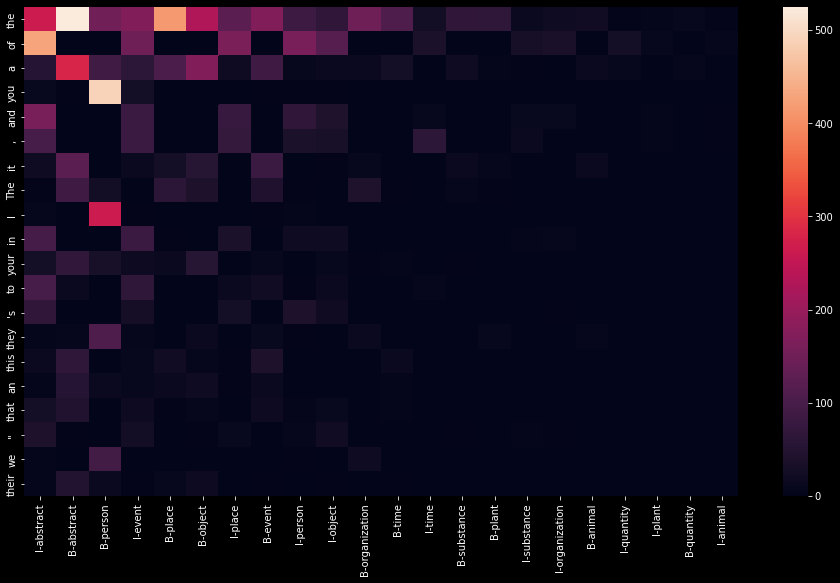

In [14]:
def get_dict(listv):
    return {x:i for i, x in enumerate(listv)}

vd = get_dict(values)
wd = get_dict(words)

corr = np.zeros((len(words), len(values)))
for _, row in df_c.iterrows():
    corr[wd[row['word']], vd[row['tag']]] += 1
import seaborn as sns
sns.heatmap(corr, 
            xticklabels=values,
            yticklabels=words)

Как видно многие слова принадлежат сразу множеству тего, поэтому простая модель слово-тег вряд ли даст хороший результат

###Baseline sklearn


In [12]:
v = DictVectorizer(sparse=False)
v.fit(df.to_dict('records'))
X_train = v.transform(ds_train.drop('tag', axis=1).to_dict('records'))
X_test = v.transform(ds_test.drop('tag', axis=1).to_dict('records'))
print(X_train.shape, X_test.shape)

y_train = ds_train.tag.values
y_test = ds_test.tag.values
classes = np.unique(df.tag.values)
classes = classes.tolist()

(44111, 9809) (18236, 9809)


In [43]:
classes = np.unique(df.tag.values)
classes = classes.tolist()

In [13]:
new_classes = classes.copy()
new_classes.pop()

'O'

Построим несколько простых моделек слово-тег

In [58]:
per = Perceptron(verbose=10, n_jobs=-1, max_iter=5)
per.partial_fit(X_train, y_train, classes)
print(classification_report(y_pred=per.predict(X_test), y_true=y_test, labels=new_classes))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


-- Epoch 1
-- Epoch 1
Norm: 9.95, NNZs: 69, Bias: -1.000000, T: 44111, Avg. loss: 0.005101
Total training time: 1.16 seconds.
-- Epoch 1
Norm: 34.29, NNZs: 930, Bias: 0.000000, T: 44111, Avg. loss: 0.072408
Total training time: 1.30 seconds.
-- Epoch 1


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.2s


Norm: 20.35, NNZs: 362, Bias: -2.000000, T: 44111, Avg. loss: 0.028315
Total training time: 1.05 seconds.
-- Epoch 1
Norm: 25.96, NNZs: 576, Bias: -2.000000, T: 44111, Avg. loss: 0.036884
Total training time: 1.06 seconds.
-- Epoch 1


[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    2.4s


Norm: 16.37, NNZs: 215, Bias: -2.000000, T: 44111, Avg. loss: 0.013874
Total training time: 0.94 seconds.
-- Epoch 1
Norm: 33.38, NNZs: 806, Bias: -2.000000, T: 44111, Avg. loss: 0.041464
Total training time: 1.05 seconds.
-- Epoch 1
Norm: 28.74, NNZs: 626, Bias: -2.000000, T: 44111, Avg. loss: 0.039877
Total training time: 0.98 seconds.
-- Epoch 1
Norm: 9.49, NNZs: 75, Bias: -2.000000, T: 44111, Avg. loss: 0.005463
Total training time: 0.90 seconds.
-- Epoch 1
Norm: 9.49, NNZs: 81, Bias: -2.000000, T: 44111, Avg. loss: 0.003378
Total training time: 0.93 seconds.
-- Epoch 1
Norm: 15.23, NNZs: 195, Bias: -2.000000, T: 44111, Avg. loss: 0.009793
Total training time: 0.93 seconds.
-- Epoch 1


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    5.1s


Norm: 17.83, NNZs: 210, Bias: -2.000000, T: 44111, Avg. loss: 0.012673
Total training time: 0.90 seconds.
-- Epoch 1
Norm: 62.81, NNZs: 2833, Bias: -1.000000, T: 44111, Avg. loss: 0.151481
Total training time: 1.27 seconds.
-- Epoch 1
Norm: 12.57, NNZs: 99, Bias: -2.000000, T: 44111, Avg. loss: 0.003106
Total training time: 0.89 seconds.
-- Epoch 1
Norm: 42.53, NNZs: 1512, Bias: -3.000000, T: 44111, Avg. loss: 0.098025
Total training time: 1.10 seconds.
-- Epoch 1


[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    7.6s


Norm: 44.08, NNZs: 1433, Bias: -1.000000, T: 44111, Avg. loss: 0.052708
Total training time: 1.04 seconds.
-- Epoch 1
Norm: 26.21, NNZs: 498, Bias: -1.000000, T: 44111, Avg. loss: 0.016254
Total training time: 0.98 seconds.
-- Epoch 1
Norm: 45.09, NNZs: 1548, Bias: -1.000000, T: 44111, Avg. loss: 0.055270
Total training time: 1.06 seconds.
-- Epoch 1
Norm: 46.94, NNZs: 1583, Bias: -3.000000, T: 44111, Avg. loss: 0.066990
Total training time: 1.09 seconds.
-- Epoch 1
Norm: 13.64, NNZs: 124, Bias: -2.000000, T: 44111, Avg. loss: 0.004466
Total training time: 0.91 seconds.
-- Epoch 1
Norm: 14.97, NNZs: 176, Bias: -2.000000, T: 44111, Avg. loss: 0.006574
Total training time: 0.91 seconds.
-- Epoch 1
Norm: 22.00, NNZs: 328, Bias: -2.000000, T: 44111, Avg. loss: 0.013194
Total training time: 0.91 seconds.
-- Epoch 1
Norm: 25.79, NNZs: 401, Bias: -1.000000, T: 44111, Avg. loss: 0.019360
Total training time: 0.91 seconds.
Norm: 95.12, NNZs: 5149, Bias: -1.000000, T: 44111, Avg. loss: 0.242774


[Parallel(n_jobs=-1)]: Done  23 out of  23 | elapsed:   12.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  23 out of  23 | elapsed:   12.1s finished


Perceptron(max_iter=5, n_jobs=-1, verbose=10)

In [61]:
sgd = SGDClassifier()
sgd.partial_fit(X_train, y_train, classes)
print(classification_report(y_pred=sgd.predict(X_test), y_true=y_test, labels=new_classes))

                precision    recall  f1-score   support

    B-abstract       0.30      0.15      0.20       798
      B-animal       0.44      0.10      0.16        42
       B-event       1.00      0.01      0.01       315
      B-object       0.20      0.05      0.08       420
B-organization       0.32      0.14      0.19       192
      B-person       0.39      0.66      0.49       823
       B-place       0.37      0.09      0.15       469
       B-plant       0.02      0.56      0.04        62
    B-quantity       0.27      0.07      0.11        44
   B-substance       0.50      0.01      0.02        95
        B-time       0.79      0.12      0.21       179
    I-abstract       0.50      0.08      0.14      2048
      I-animal       0.38      0.35      0.37        43
       I-event       0.71      0.03      0.05       934
      I-object       0.10      0.64      0.17       782
I-organization       0.43      0.19      0.27       278
      I-person       0.54      0.15      0.24  

In [62]:
pa =PassiveAggressiveClassifier()
pa.partial_fit(X_train, y_train, classes)
print(classification_report(y_pred=pa.predict(X_test), y_true=y_test, labels=new_classes))

                precision    recall  f1-score   support

    B-abstract       0.10      0.69      0.17       798
      B-animal       0.42      0.12      0.19        42
       B-event       0.09      0.18      0.12       315
      B-object       0.38      0.03      0.06       420
B-organization       0.66      0.11      0.19       192
      B-person       0.75      0.47      0.58       823
       B-place       0.44      0.09      0.15       469
       B-plant       1.00      0.10      0.18        62
    B-quantity       0.29      0.05      0.08        44
   B-substance       0.21      0.04      0.07        95
        B-time       0.70      0.17      0.28       179
    I-abstract       0.37      0.26      0.31      2048
      I-animal       0.38      0.37      0.38        43
       I-event       0.47      0.05      0.09       934
      I-object       0.28      0.23      0.25       782
I-organization       0.56      0.15      0.24       278
      I-person       0.69      0.11      0.18  

In [63]:
nb = MultinomialNB(alpha=0.01)
nb.partial_fit(X_train, y_train, classes)
print(classification_report(y_pred=nb.predict(X_test), y_true=y_test, labels = new_classes))

                precision    recall  f1-score   support

    B-abstract       0.22      0.56      0.32       798
      B-animal       0.65      0.26      0.37        42
       B-event       0.15      0.02      0.04       315
      B-object       0.31      0.07      0.11       420
B-organization       0.43      0.12      0.19       192
      B-person       0.72      0.61      0.66       823
       B-place       0.42      0.14      0.22       469
       B-plant       0.69      0.15      0.24        62
    B-quantity       0.42      0.11      0.18        44
   B-substance       0.36      0.04      0.08        95
        B-time       0.64      0.20      0.30       179
    I-abstract       0.39      0.31      0.34      2048
      I-animal       0.50      0.37      0.43        43
       I-event       0.34      0.14      0.20       934
      I-object       0.43      0.20      0.27       782
I-organization       0.39      0.23      0.29       278
      I-person       0.50      0.24      0.32  

Результаты так себе, примерно 50проц precision, попробуем также учесть соседние слова и позиционные теги

In [7]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
postags = nltk.pos_tag([x for x,y in train_sents[0]]) 
postags

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


[('The', 'DT'),
 ('back', 'NN'),
 ('of', 'IN'),
 ('my', 'PRP$'),
 ('jersey', 'NN'),
 ('says', 'VBZ'),
 ('"', 'IN'),
 ('The', 'DT'),
 ('Poet', 'NNP'),
 ("'", 'POS'),
 ('because', 'IN'),
 ('growing', 'VBG'),
 ('up', 'RP'),
 ('that', 'DT'),
 ('was', 'VBD'),
 ('my', 'PRP$'),
 ('nickname', 'NN'),
 ('.', '.')]

In [8]:
def word2features(sent, i):
    word = sent[i][0]
    postag = sent[i][1]
    
    features = {
        'bias': 1.0, 
        'word.lower()': word.lower(), 
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
        'postag': postag,
        'postag[:2]': postag[:2],
    }
    if i > 0:
        word1 = sent[i-1][0]
        postag1 = sent[i-1][1]
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
            '-1:postag': postag1,
            '-1:postag[:2]': postag1[:2],
        })
    else:
        features['BOS'] = True
    if i < len(sent)-1:
        word1 = sent[i+1][0]
        postag1 = sent[i+1][1]
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
            '+1:postag': postag1,
            '+1:postag[:2]': postag1[:2],
        })
    else:
        features['EOS'] = True
    return features
def sent2features(sent):
    pos_tags = nltk.pos_tag([x for x,y in sent])
    return [word2features(pos_tags, i) for i in range(len(pos_tags))]
def sent2labels(sent):
    return [label for token, label in sent]
def sent2tokens(sent):
    return [token for token, label in sent]

In [9]:
X_train = [sent2features(s) for s in train_sents]
y_train = [sent2labels(s) for s in train_sents]

In [10]:
X_test = [sent2features(s) for s in test_sents]
y_test = [sent2labels(s) for s in test_sents]

In [34]:
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=0.1,
    c2=0.1,
    max_iterations=1000,
    all_possible_transitions=True
)
crf.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


CRF(algorithm='lbfgs', all_possible_transitions=True, c1=0.1, c2=0.1,
    keep_tempfiles=None, max_iterations=1000)

In [37]:
y_pred = crf.predict(X_test)
print(metrics.flat_classification_report(y_test, y_pred, labels = classes))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=['B-abstract', 'B-animal', 'B-event', 'B-object', 'B-organization', 'B-person', 'B-place', 'B-plant', 'B-quantity', 'B-substance', 'B-time', 'I-abstract', 'I-animal', 'I-event', 'I-object', 'I-organization', 'I-person', 'I-place', 'I-plant', 'I-quantity', 'I-substance', 'I-time', 'O'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


                precision    recall  f1-score   support

    B-abstract       0.42      0.43      0.43       798
      B-animal       0.62      0.38      0.47        42
       B-event       0.33      0.28      0.30       315
      B-object       0.47      0.36      0.41       420
B-organization       0.55      0.33      0.41       192
      B-person       0.74      0.69      0.71       823
       B-place       0.53      0.50      0.51       469
       B-plant       0.61      0.32      0.42        62
    B-quantity       0.35      0.20      0.26        44
   B-substance       0.50      0.29      0.37        95
        B-time       0.62      0.54      0.58       179
    I-abstract       0.43      0.49      0.46      2048
      I-animal       0.64      0.33      0.43        43
       I-event       0.20      0.37      0.26       934
      I-object       0.40      0.31      0.35       782
I-organization       0.50      0.31      0.39       278
      I-person       0.53      0.53      0.53  

Получили примерно такой же результат, все таки нужно смотреть на все предложение целиком

### NN models - LSTM

In [6]:
import tensorflow as tf

tokeniser= tf.keras.preprocessing.text.Tokenizer(lower=False,filters='')
tokeniser.fit_on_texts([[x[0] for x in s] for s in train_sents + test_sents])

In [7]:
print("Vocab size of Tokeniser ",len(tokeniser.word_index)+1) ## Adding one since 0 is reserved for padding

Vocab size of Tokeniser  9787


In [8]:
encoded_sentence_train = tokeniser.texts_to_sequences([[x[0] for x in s] for s in train_sents])
encoded_sentence_test = tokeniser.texts_to_sequences([[x[0] for x in s] for s in test_sents])

In [9]:
words = set(list(df['word'].values))
words.add('PAD')
n_words = len(words)

tags = list(set(df["tag"].values))
n_tags = len(tags)
n_tags, n_words

(23, 9787)

In [10]:
largest_sen = max(len(sen) for sen in encoded_sentence_train + encoded_sentence_test)
print('biggest sentence has {} words'.format(largest_sen))

biggest sentence has 95 words


(array([161., 148., 240., 259., 247., 253., 247., 268., 127., 187., 223.,
        185., 179., 136., 113., 106.,  56.,  80.,  60.,  39.,  40.,  30.,
         17.,  14.,  11.,  12.,  15.,   8.,   6.,   4.,   3.,   3.,   2.,
          4.,   2.,   2.,   0.,   1.,   3.,   0.,   0.,   0.,   1.,   0.,
          1.,   0.,   0.,   0.,   0.,   2.]),
 array([ 1.  ,  2.88,  4.76,  6.64,  8.52, 10.4 , 12.28, 14.16, 16.04,
        17.92, 19.8 , 21.68, 23.56, 25.44, 27.32, 29.2 , 31.08, 32.96,
        34.84, 36.72, 38.6 , 40.48, 42.36, 44.24, 46.12, 48.  , 49.88,
        51.76, 53.64, 55.52, 57.4 , 59.28, 61.16, 63.04, 64.92, 66.8 ,
        68.68, 70.56, 72.44, 74.32, 76.2 , 78.08, 79.96, 81.84, 83.72,
        85.6 , 87.48, 89.36, 91.24, 93.12, 95.  ]),
 <a list of 50 Patch objects>)

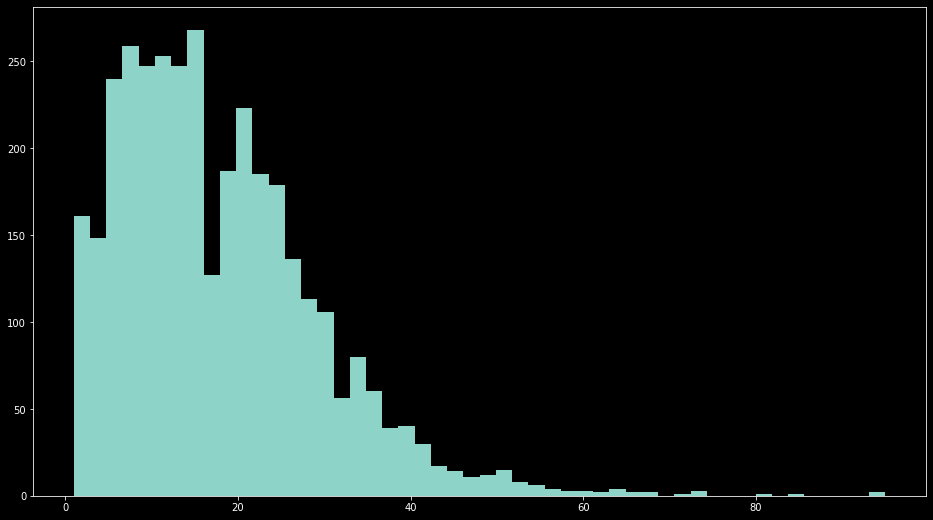

In [11]:
plt.hist([len(sen) for sen in train_sents + test_sents], bins = 50)

Максимальная длина 95, можно так и взять, без обрезки

In [12]:
max_len=96
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

padded_train =pad_sequences(maxlen=max_len,sequences=encoded_sentence_train,padding="post",value=0)
padded_test =pad_sequences(maxlen=max_len,sequences=encoded_sentence_test,padding="post",value=0)
padded_train.shape

(2495, 96)

In [65]:
from keras.preprocessing.sequence import pad_sequences
tags2index = {t:i for i,t in enumerate(tags)}
index2tags = {i:t for i,t in enumerate(tags)}
y_train = [[tags2index[w[1]] for w in s] for s in train_sents]
y_train = pad_sequences(maxlen=max_len, sequences=y_train, padding="post", value=tags2index["O"])
y_test = [[tags2index[w[1]] for w in s] for s in test_sents]
y_test = pad_sequences(maxlen=max_len, sequences=y_test, padding="post", value=tags2index["O"])
y_train.shape

(2495, 96)

In [74]:
y_train= [to_categorical(i, num_classes = n_tags) for i in y_train]
y_test= [to_categorical(i, num_classes = n_tags) for i in y_test]
y_train[0].shape

(96, 23)

In [39]:
from tensorflow.keras import Model,Input
from tensorflow.keras.layers import LSTM,Embedding,Dense
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D,Bidirectional

embedding_dim=128
vocab_size=len(tokeniser.word_index)+1
lstm_units=128
max_len=96

reg = tf.keras.regularizers.L1L2(0.01, 0.005)

input_word = Input(shape = (max_len,))
model = Embedding(input_dim = vocab_size+1,output_dim = embedding_dim,input_length = max_len)(input_word)

model = LSTM(units=embedding_dim,return_sequences=True, bias_regularizer=reg)(model)
out = TimeDistributed(Dense(n_tags,activation = 'softmax'))(model)
model = Model(input_word,out)
model.summary()

model.compile(optimizer = 'adam',loss = 'categorical_crossentropy',metrics = ['accuracy'])
history = model.fit(padded_train,np.array(y_train),validation_data=(padded_test,np.array(y_test)), batch_size = 128,epochs = 40)

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 96)]              0         
                                                                 
 embedding_14 (Embedding)    (None, 96, 128)           1252864   
                                                                 
 lstm_21 (LSTM)              (None, 96, 128)           131584    
                                                                 
 time_distributed_9 (TimeDis  (None, 96, 23)           2967      
 tributed)                                                       
                                                                 
Total params: 1,387,415
Trainable params: 1,387,415
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
20/20 [==============================] - 10s 412ms/step - loss: 3.3915 - accuracy: 0.8524 - val_loss: 2.

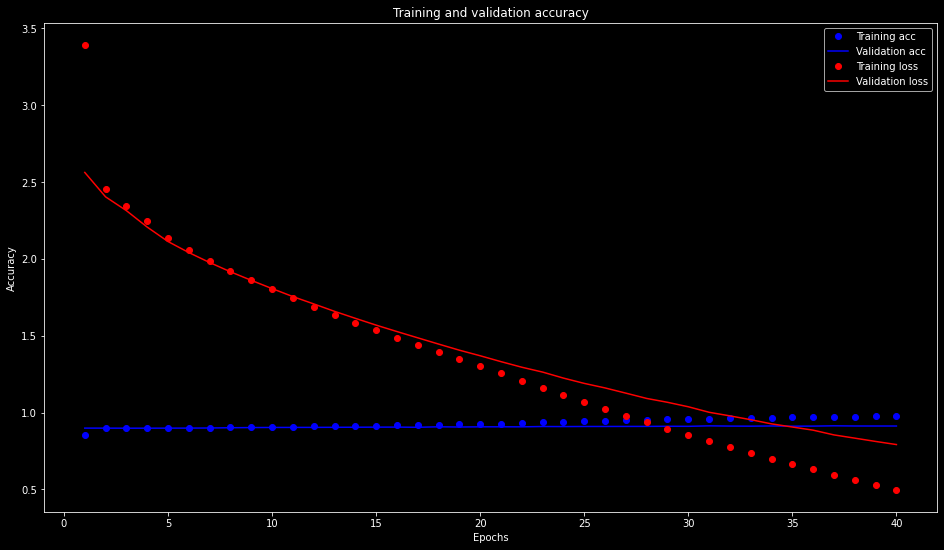

In [80]:
history_dict = history.history
history_dict.keys()
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.clf()   # clear figure

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [46]:
classes = np.unique(df.tag.values)
classes = classes.tolist()

(96, 23)

In [79]:
res = model.predict(padded_test)
res[0].shape

ans = []
anst = []
match = 0
total = 0
for i, sent in enumerate(res):
    for j, w in enumerate(sent):
        ans.append(index2tags[np.argmax(w)])
        anst.append(index2tags[np.argmax(y_test[i][j])])
        #print(ans[-1], anst[-1], np.argmax(y_test[i][j]))
        total += 1
        match += int(ans[-1] == anst[-1])

ans = np.array(ans)
anst = np.array(anst)
ans.shape, anst.shape, match/total

print(classification_report(y_pred=ans, y_true=anst, labels=classes))

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                precision    recall  f1-score   support

    B-abstract       0.25      0.32      0.28       798
      B-animal       0.00      0.00      0.00        42
       B-event       0.11      0.07      0.09       315
      B-object       0.18      0.13      0.15       420
B-organization       0.00      0.00      0.00       192
      B-person       0.65      0.57      0.61       823
       B-place       0.22      0.26      0.24       469
       B-plant       0.00      0.00      0.00        62
    B-quantity       0.00      0.00      0.00        44
   B-substance       0.00      0.00      0.00        95
        B-time       0.28      0.12      0.17       179
    I-abstract       0.37      0.37      0.37      2048
      I-animal       0.00      0.00      0.00        43
       I-event       0.19      0.29      0.23       934
      I-object       0.32      0.25      0.28       782
I-organization       0.23      0.21      0.22       278
      I-person       0.44      0.32      0.37  

Обычная lstm уже дает хороший результат, но если посмотреть на каждый тег, видно что часть редких тегов просто пропущена, несмотря на регуляризацию моделька переобучается, а хорошая точность достигается за счет тега О.

In [81]:
input_word = Input(shape = (max_len,))
x = Embedding(input_dim = vocab_size+1,output_dim = embedding_dim,input_length = max_len)(input_word)

reg = tf.keras.regularizers.L1L2(0.001, 0.0005)

x = Bidirectional(LSTM(units=64, return_sequences=True,
                    recurrent_dropout=0.2, dropout=0.2, bias_regularizer=reg))(x)
x_rnn = Bidirectional(LSTM(units=64, return_sequences=True,
                        recurrent_dropout=0.2, dropout=0.2, bias_regularizer=reg))(x)
x = tf.keras.layers.add([x, x_rnn])  # residual connection to the first biLSTM
out = TimeDistributed(Dense(n_tags, activation="softmax"))(x)

model = Model(input_word,out)
model.summary()

model.compile(optimizer = 'adam',loss = 'categorical_crossentropy',metrics = ['accuracy'])
history = model.fit(padded_train,np.array(y_train),validation_data=(padded_test,np.array(y_test)), batch_size = 128,epochs = 10)

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_16 (InputLayer)          [(None, 96)]         0           []                               
                                                                                                  
 embedding_15 (Embedding)       (None, 96, 128)      1252864     ['input_16[0][0]']               
                                                                                                  
 bidirectional_14 (Bidirectiona  (None, 96, 128)     98816       ['embedding_15[0][0]']           
 l)                                                                                               
                                                                                                  
 bidirectional_15 (Bidirectiona  (None, 96, 128)     98816       ['bidirectional_14[0][0]']

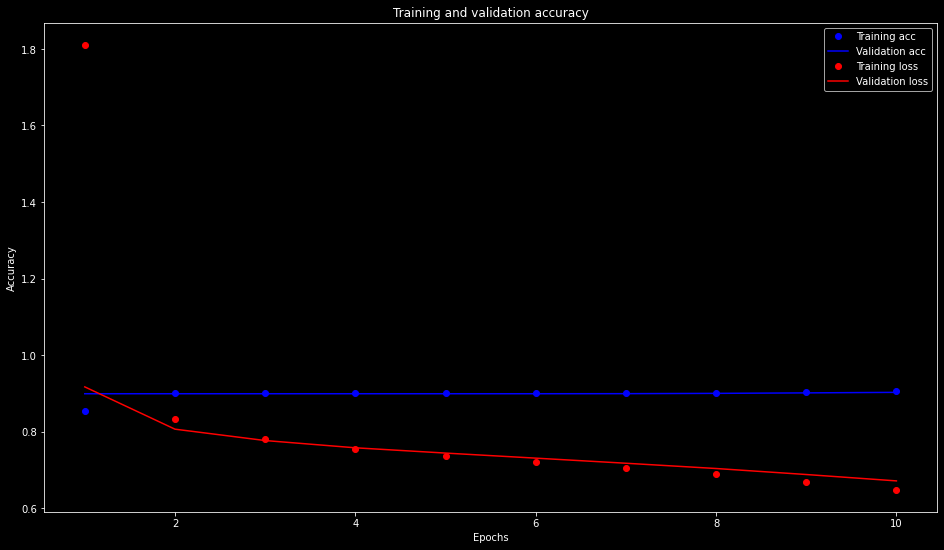

In [82]:
history_dict = history.history
history_dict.keys()
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.clf()   # clear figure

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [84]:
res = model.predict(padded_test)
res[0].shape

ans = []
anst = []
match = 0
total = 0
for i, sent in enumerate(res):
    for j, w in enumerate(sent):
        ans.append(index2tags[np.argmax(w)])
        anst.append(index2tags[np.argmax(y_test[i][j])])
        #print(ans[-1], anst[-1], np.argmax(y_test[i][j]))
        total += 1
        match += int(ans[-1] == anst[-1])

ans = np.array(ans)
anst = np.array(anst)
ans.shape, anst.shape, match/total

print(classification_report(y_pred=ans, y_true=anst, labels=classes))

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                precision    recall  f1-score   support

    B-abstract       0.00      0.00      0.00       798
      B-animal       0.00      0.00      0.00        42
       B-event       0.00      0.00      0.00       315
      B-object       0.00      0.00      0.00       420
B-organization       0.00      0.00      0.00       192
      B-person       0.00      0.00      0.00       823
       B-place       0.00      0.00      0.00       469
       B-plant       0.00      0.00      0.00        62
    B-quantity       0.00      0.00      0.00        44
   B-substance       0.00      0.00      0.00        95
        B-time       0.00      0.00      0.00       179
    I-abstract       0.24      0.29      0.26      2048
      I-animal       0.00      0.00      0.00        43
       I-event       0.18      0.12      0.15       934
      I-object       0.00      0.00      0.00       782
I-organization       0.00      0.00      0.00       278
      I-person       0.18      0.01      0.02  

Bidirectional lstm получился еще хуже и переобучился на тег О

### Conclusions


При использовании нейросетевых подходов нужно как-то учитывать доминирование тега О при обучении модели, возможно поможет кастомный лосс или уменьшение количества О слов у входа